In [1]:
### Package Imports ###
import tensorflow as tf
import keras
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import os
import time
import h5py
import functools
import mitdeeplearning as mdl
from tqdm import tqdm

2024-06-23 14:05:31.955635: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-23 14:05:31.955680: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-23 14:05:31.956395: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-23 14:05:31.962149: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
### Package Setup ###
start_time = time.localtime(time.time())

CWD = os.getcwd()
# print(CWD)

matplotlib.rcParams['font.family'] = "Times New Roman"

### Ensure training on GPU ###
assert len(tf.config.list_physical_devices('GPU')) > 0
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)

2024-06-23 14:05:34.115751: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-23 14:05:34.139811: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-23 14:05:34.139851: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.


# Data Loading

In [3]:
### Functions: Load and Visualize Dataset ###

### Function: load dataset ###
@keras.saving.register_keras_serializable(package='capstone',name='load_dataset')
def load_dataset(path_to_training_data):
    with h5py.File(path_to_training_data) as f:
        # Print the keys (names) of all groups and datasets in the file
        print("Keys:", list(f.keys()))

        # Iterate through each key and print more detailed information
        for key in f.keys():
            if isinstance(f[key], h5py.Dataset):
                print(f"Dataset: {key}")
                print("  Shape:", f[key].shape)
                print("  Data type:", f[key].dtype)
                
    ### Instantiate Loader Function ###
    return mdl.lab2.TrainingDatasetLoader(path_to_training_data)

### Function: visualize dataset ###
@keras.saving.register_keras_serializable(package='capstone',name='visualize_dataset')
def visualize_dataset(loader):
    ### Visualize our data ###
    number_of_training_examples = loader.get_train_size()
    print(number_of_training_examples)
    (images, labels) = loader.get_batch(100)
    malignant_images = images[np.where(labels==1)[0]]
    benign_images = images[np.where(labels==0)[0]]

    idx_malignant = 23
    idx_benign = 9

    plt.figure(figsize=(5,5))
    plt.subplot(1, 2, 1)
    plt.imshow(malignant_images[idx_malignant])
    plt.title("Malignant"); plt.grid(False)

    plt.subplot(1, 2, 2)
    plt.imshow(benign_images[idx_benign])
    plt.title("Benign"); plt.grid(False)

In [4]:
### Instantiate Loaders: train/val 90/10 ###
loader_dataset1 = load_dataset(f'{CWD}/data/.h5files/dataset1.h5')
loader_dataset2 = load_dataset(f'{CWD}/data/.h5files/dataset2.h5')
loader_dataset3 = load_dataset(f'{CWD}/data/.h5files/dataset3.h5')

loader_val = load_dataset(f'{CWD}/data/.h5files/validation.h5')

Keys: ['images', 'labels']
Dataset: images
  Shape: (1581, 64, 64, 3)
  Data type: uint8
Dataset: labels
  Shape: (1581, 1)
  Data type: uint8
Opening /mnt/e/AP Research/Polished-Capstone/src/data/.h5files/dataset1.h5
Loading data into memory...
Keys: ['images', 'labels']
Dataset: images
  Shape: (656, 64, 64, 3)
  Data type: uint8
Dataset: labels
  Shape: (656, 1)
  Data type: uint8
Opening /mnt/e/AP Research/Polished-Capstone/src/data/.h5files/dataset2.h5
Loading data into memory...
Keys: ['images', 'labels']
Dataset: images
  Shape: (2110, 64, 64, 3)
  Data type: uint8
Dataset: labels
  Shape: (2110, 1)
  Data type: uint8
Opening /mnt/e/AP Research/Polished-Capstone/src/data/.h5files/dataset3.h5
Loading data into memory...
Keys: ['images', 'labels']
Dataset: images
  Shape: (395, 64, 64, 3)
  Data type: uint8
Dataset: labels
  Shape: (395, 1)
  Data type: uint8
Opening /mnt/e/AP Research/Polished-Capstone/src/data/.h5files/validation.h5
Loading data into memory...


1581
656
2110
395


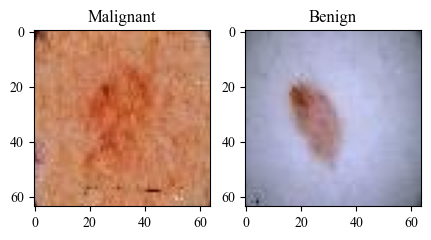

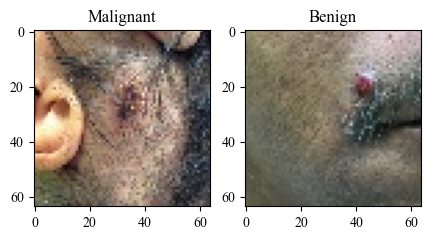

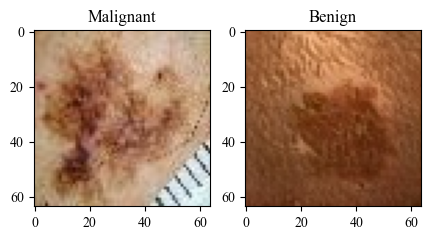

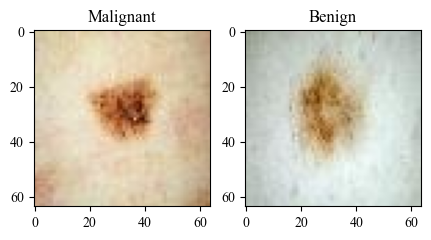

In [5]:
# ### Visualize Training Datasets ###
visualize_dataset(loader_dataset1)
visualize_dataset(loader_dataset2)
visualize_dataset(loader_dataset3)
visualize_dataset(loader_val)

# Create Model Architectures

In [6]:
### Standard CNN ###

"""
Instantiation helper functions:
- resize_images: used in lambda function layer to resize the input images
"""
@keras.saving.register_keras_serializable(package='capstone', name='resize_images')
def resize_images(x):
    return tf.image.resize(x, (64, 64))

"""
Instantiation function:
- make_standard_ResNet50_V2: instantiates a new keras model with the ResNet50v2 CNN architecture. 
"""
@keras.saving.register_keras_serializable(package='capstone', name='make_standard_ResNet50_V2')
def make_standard_ResNet50_V2(n_outputs = 1):
    
    Resize = tf.keras.layers.Lambda(resize_images)
    Flatten = tf.keras.layers.Flatten
    Dense = functools.partial(tf.keras.layers.Dense, activation='relu')
    ResNet50V2 = tf.keras.applications.ResNet50V2(
        include_top=False,
        weights="imagenet", # Utilizing Transfer Learning, also maintains consistency
        input_tensor=None,
        input_shape=(64,64,3),
        pooling=None,
        classes=1000,
        classifier_activation="softmax",
    )
    ResNet50V2 = tf.keras.Model(inputs = ResNet50V2.layers[1].input, 
                                outputs = ResNet50V2.layers[-1].output)

    model = tf.keras.Sequential()
    
    model.add(Resize)
    model.add(ResNet50V2)
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Dense(n_outputs, activation=None))

    return model

In [7]:
### DB-VAE ###

"""
Instantiation helper functions:
- make_decoder_network: creates decoder section of the debiasing-variational autoencoder. 
    Structure is akin to ResNet50v2 except inverted.
- sampling: VAE reparameterization trick (Amini 2024)
- vae_loss_function: as its name suggests, a VAE loss function, also a helper function for debiasing_loss_function
- debiasing_loss_function: as its name suggests, a loss function for the debiasing portion of the DB-VAE

"""
@keras.saving.register_keras_serializable(package='capstone', name='make_decoder_network')
def make_decoder_network(latent_dim = 100, n_filters = 12 ):
    """
    Layer Types, Functional Definition
    """
    Conv2DTranspose = functools.partial(tf.keras.layers.Conv2DTranspose, padding='same', activation='relu')
    Dense = functools.partial(tf.keras.layers.Dense, activation='relu')
    Reshape = tf.keras.layers.Reshape 
    BatchNormalization = tf.keras.layers.BatchNormalization
    LeakyReLU = tf.keras.layers.LeakyReLU
    # Decoder
    decoder = tf.keras.Sequential([
        Dense(units=4*4*6*n_filters),
        Reshape(target_shape=(4,4,6*n_filters)),

        Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),

        Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),

        Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),

        Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', activation='sigmoid')
    ])
    return decoder

@keras.saving.register_keras_serializable(package='capstone', name='sampling_VAE_reparameterization')
def sampling(z_mean, z_logsigma):
    batch, latent_dim = z_mean.shape
    epsilon = tf.random.normal(shape=(batch, latent_dim))
    z = z_mean + tf.math.exp(0.5 * z_logsigma) * epsilon
    return z

@keras.saving.register_keras_serializable(package='capstone', name='vae_loss_function')
def vae_loss_function(x, x_recon, mu, logsigma, kl_weight=0.0005):
  latent_loss = 0.5 * tf.reduce_sum(tf.exp(logsigma) + tf.square(mu) - 1.0 - logsigma, axis=1)
  reconstruction_loss = tf.reduce_mean(tf.abs(x-x_recon), axis=(1,2,3))
  vae_loss = kl_weight * latent_loss + reconstruction_loss
  return vae_loss

@keras.saving.register_keras_serializable(package='capstone',name='debiasing_loss_function')
def debiasing_loss_function(x, x_pred, y, y_logit, mu, logsigma):
  vae_loss = vae_loss_function(x, x_pred, mu, logsigma)
  classification_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_logit)
  malignance_indicator = tf.cast(tf.equal(y, 1), tf.float32)
  total_loss = tf.reduce_mean(
      classification_loss +
      malignance_indicator * vae_loss
  )
  return total_loss, classification_loss

"""
Instantiation:
Class definition of the DB_VAE
"""
@keras.saving.register_keras_serializable(package='capstone')
class DB_VAE(tf.keras.Model):
  def __init__(self, latent_dim):
    super(DB_VAE, self).__init__()
    self.latent_dim = latent_dim

    # Define the number of outputs for the encoder. Recall that we have
    # `latent_dim` latent variables, as well as a supervised output for the
    # classification.
    num_encoder_dims = 2*self.latent_dim + 1

    self.encoder = make_standard_ResNet50_V2(num_encoder_dims)
    self.decoder = make_decoder_network()

  def encode(self, x):
    encoder_output = self.encoder(x)
    y_logit = tf.expand_dims(encoder_output[:, 0], -1)
    z_mean = encoder_output[:, 1:self.latent_dim+1]
    z_logsigma = encoder_output[:, self.latent_dim+1:]

    return y_logit, z_mean, z_logsigma

  def reparameterize(self, z_mean, z_logsigma):
    z = sampling(z_mean, z_logsigma)
    return z

  def decode(self, z):
    reconstruction = self.decoder(z)
    return reconstruction

  def call(self, x):
    y_logit, z_mean, z_logsigma = self.encode(x)
    z = self.reparameterize(z_mean, z_logsigma)
    recon = self.decode(z)
    return y_logit, z_mean, z_logsigma, recon

  def predict(self, x):
    y_logit, z_mean, z_logsigma = self.encode(x)
    return y_logit
  

"""
Training helper functions:
- get_latent_mu: finds mean of latent distribution
- get_training_sample_probabilities: recomputes the sampling probabilities for images within a batch 
    based on how they distribute across the training data
"""
# Function to return the means for an input image batch
@keras.saving.register_keras_serializable(package='capstone',name='get_latent_mu')
def get_latent_mu(images, dbvae, batch_size=1024, latent_dim=100):
    N = images.shape[0]
    mu = np.zeros((N, latent_dim))
    for start_ind in range(0, N, batch_size):
        end_ind = min(start_ind+batch_size, N+1)
        batch = (images[start_ind:end_ind]).astype(np.float32)/255.
        _, batch_mu, _ = dbvae.encode(batch)
        mu[start_ind:end_ind] = batch_mu
    return mu

@keras.saving.register_keras_serializable(package='capstone',name='get_training_sample_probabilities')
def get_training_sample_probabilities(images, dbvae, bins=10, smoothing_fac=0.001, latent_dim=100):
    print("Recomputing the sampling probabilities")
    mu = get_latent_mu(images, dbvae)
    training_sample_p = np.zeros(mu.shape[0])
    for i in range(latent_dim):
        latent_distribution = mu[:,i]
        hist_density, bin_edges =  np.histogram(latent_distribution, density=True, bins=bins)
        bin_edges[0] = -float('inf')
        bin_edges[-1] = float('inf')
        bin_idx = np.digitize(latent_distribution, bin_edges)
        hist_smoothed_density = hist_density + smoothing_fac
        hist_smoothed_density = hist_smoothed_density / np.sum(hist_smoothed_density)
        p = 1.0/(hist_smoothed_density[bin_idx-1])
        p = p / np.sum(p)
        training_sample_p = np.maximum(p, training_sample_p)
    training_sample_p /= np.sum(training_sample_p)

    return training_sample_p

In [8]:
### Set Training Hyperparameters ###

### Hyperparameters for CNN Training ###
params_CNN = dict( 
  batch_size = 32,
  num_epochs = 25,
  learning_rate = 1e-2, # 5e-4 was initial rate set by Amini
  min_lr = 1e-5, # for adaptive learning rate
  factor = 0.8, # for adaptive learning rate
  patience_lr = 5, # for adaptive learning rate
  patience_stop = 10, # for early stopping
  optimizer = 'SGD', # 'Adam' or 'SGD'
)

### Hyperparameters for DB-VAE Training ###
params_DB_VAE = dict(
    batch_size = 32,
    num_epochs = 25, 
    learning_rate = 5e-4,
    latent_dim = 100,
    optimizer = 'SGD', # 'Adam' or 'SGD'
)

# Training

In [9]:
@keras.saving.register_keras_serializable(package='capstone',name='graph_metrics')
def graph_metrics(model_num, completed_epochs, metrics):
    size_axis_titles = 16
    size_title = 18
    size_legend = 14
    
    fig, [ax_acc, ax_loss] = plt.subplots(1, 2)
    fig.set_size_inches((16, 7))
    fig.suptitle(f'Model {model_num} Training', fontsize=size_title)
    
    ax_acc.set_xlabel('Epoch', fontsize=size_axis_titles)
    ax_acc.set_ylabel('Accuracy', fontsize=size_axis_titles)
    ax_acc.set_xbound(1, completed_epochs+1)
    ax_acc.set_ybound(0, 1.0)
    ax_acc.plot(metrics['train_acc'], label='Training')
    ax_acc.plot(metrics['val_acc'], label='Validation')
    ax_acc.legend(loc='upper right', fontsize=size_legend)

    ax_loss.set_xlabel('Epoch', fontsize=size_axis_titles)
    ax_loss.set_ylabel('Loss', fontsize=size_axis_titles)
    ax_loss.set_xbound(1, completed_epochs+1)
    ax_loss.set_ybound(0, 2.5)
    ax_loss.plot(metrics['train_loss'], label='Training')
    ax_loss.plot(metrics['val_loss'], label='Validation')
    ax_loss.legend(loc='upper right', fontsize=size_legend)

    fig.savefig(f'{CWD}/models/Model_{model_num}_Training.png', bbox_inches='tight')
    fig.show()

In [10]:
@keras.saving.register_keras_serializable(package='capstone',name='train_base_CNN')
def train_base_CNN(model_num, data_loader, params, validation_loader):
    model = make_standard_ResNet50_V2()
    if (params['optimizer'] == 'Adam'):
        optimizer = tf.keras.optimizers.Adam(params['learning_rate']) # Adam
    elif (params['optimizer'] == 'SGD'):
        optimizer = tf.keras.optimizers.SGD(learning_rate = params['learning_rate']) # stochastic gradient descent
    # Binary classification task necessitates binary crossentropy loss
    loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits = True)

    train_acc_metric = tf.keras.metrics.BinaryAccuracy()
    train_loss_metric = tf.keras.metrics.BinaryCrossentropy()
    val_acc_metric = tf.keras.metrics.BinaryAccuracy()
    val_loss_metric = tf.keras.metrics.BinaryCrossentropy()

    @tf.function
    def train_step(x,y):
        with tf.GradientTape() as tape:
            logits = model(x, training=True)
            loss_value = loss_fn(y, logits)
        grads = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        train_acc_metric.update_state(y, logits)
        train_loss_metric.update_state(y, logits)
        return loss_value
    
    @tf.function
    def test_step(x,y):
        logits = model(x, training=False)
        val_acc_metric.update_state(y, logits)
        val_loss_metric.update_state(y, logits)

    completed_epochs = 0 
    ### Conditions for Early Stopping ###
    wait_val_loss = 0
    best_val_loss = float('inf')
    ### Conditions for Adjusting Learning Rate ###
    wait_val_acc = 0
    best_val_acc = float(0)

    ### Store Metrics ###
    TRAIN_ACC = []
    TRAIN_LOSS = []
    VAL_ACC = []
    VAL_LOSS = []

    for epoch in range(params['num_epochs']):
        print("\nStart of epoch %d" % (epoch,))
        start_time = time.time()

        ### Training Steps ###
        for idx in tqdm(range(data_loader.get_train_size()//params["batch_size"])):
            x, y = data_loader.get_batch(params['batch_size'])
            loss_value = train_step(x, y)
        
        train_acc = train_acc_metric.result()
        train_loss = train_loss_metric.result()
        train_acc_metric.reset_states()
        train_loss_metric.reset_states()
        print("Training acc over epoch: %.4f" % (train_acc.numpy()))
        print("Training loss over epoch: %.4f" % (train_loss.numpy()))

        ### Validation Steps ###
        for idx in tqdm(range(validation_loader.get_train_size()//params['batch_size'])):
            x_val, y_val = validation_loader.get_batch(params['batch_size'])
            test_step(x_val, y_val)
        
        val_acc = val_acc_metric.result()
        val_loss = val_loss_metric.result()
        val_acc_metric.reset_states()
        val_loss_metric.reset_states()
        print("Validation acc: %.4f" % (float(val_acc),))
        print("Validation loss: %.4f" % (float(val_loss),))
        print("Time taken: %.2fs" % (time.time() - start_time))

        ### Store Metrics ###
        TRAIN_ACC.append(float(train_acc))
        TRAIN_LOSS.append(float(train_loss))
        VAL_ACC.append(float(val_acc))
        VAL_LOSS.append(float(val_loss))

        completed_epochs += 1
        wait_val_loss += 1
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            wait_val_loss = 0
        if wait_val_loss >= params['patience_stop']:
            print("EARLY STOP")
            break

        wait_val_acc += 1
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            wait_val_acc = 0
        if wait_val_acc >= params['patience_lr']:
            if (optimizer.lr != params['min_lr']): # if the optimizer isn't at minimum LR
                print("learning rate changed")
                old_lr = optimizer.lr
                optimizer.lr = old_lr * params['factor'] # multiply optimizer LR by factor
                new_lr = optimizer.lr
                assert abs(old_lr - new_lr) < 1e-9 # ensure the rate actually did change
                # I set the tolerance to 1e-9; that's way below the min LR.
    
    ### Compile Model Training Metrics ###
    metrics = {
        'train_acc': TRAIN_ACC,
        'train_loss': TRAIN_LOSS,
        'val_acc': VAL_ACC,
        'val_loss': VAL_LOSS,
    }
    metrics = pd.DataFrame(metrics)
    print(metrics)

    ### Visualize Training Metrics ###
    graph_metrics(model_num, completed_epochs, metrics)

    ### Save Model ###
    model.save(f'{CWD}/models/Model_{model_num}.keras')
    
    return completed_epochs, metrics

In [11]:
@keras.saving.register_keras_serializable(package='capstone',name='train_DB_VAE')
def train_DB_VAE(model_num, data_loader, params, validation_loader):
    model = DB_VAE(params['latent_dim'])

    if (params['optimizer'] == 'Adam'):
        optimizer = tf.keras.optimizers.Adam(params['learning_rate']) # Adam
    elif (params['optimizer'] == 'SGD'):
        optimizer = tf.keras.optimizers.SGD(learning_rate = params['learning_rate']) # stochastic gradient descent

    ### We'll track typical binary losses as usual ###
    train_acc_metric = tf.keras.metrics.BinaryAccuracy()
    train_loss_metric = tf.keras.metrics.BinaryCrossentropy()
    val_acc_metric = tf.keras.metrics.BinaryAccuracy()
    val_loss_metric = tf.keras.metrics.BinaryCrossentropy()
    
    
    @tf.function
    def debiasing_train_step(x, y):
        with tf.GradientTape() as tape:
            y_logit, z_mean, z_logsigma, x_recon = model(x)
            loss, class_loss = debiasing_loss_function(x, x_recon, y, y_logit, z_mean, z_logsigma)
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        train_acc_metric.update_state(y, y_logit)
        train_loss_metric.update_state(y, y_logit)
        return loss
    
    @tf.function
    def test_step(x,y):
        logits, _, _, _ = model(x, training=False)
        val_acc_metric.update_state(y, logits)
        val_loss_metric.update_state(y, logits)

    all_imgs = data_loader.get_all_train_faces()

    completed_epochs = 0 
    ### Store Metrics ###
    TRAIN_ACC = []
    TRAIN_LOSS = []
    VAL_ACC = []
    VAL_LOSS = []
    DB_LOSS = []
    for epoch in range(params["num_epochs"]):
        print("\nStart of epoch %d" % (epoch,))
        start_time = time.time()

        p_lesions = get_training_sample_probabilities(all_imgs, model)
        db_loss = np.empty(shape=[data_loader.get_train_size() // params["batch_size"]])

        for idx in tqdm(range(data_loader.get_train_size() // params["batch_size"])):
            # load a batch of data
            (x, y) = data_loader.get_batch(params["batch_size"], p_pos=p_lesions)

            # loss optimization
            loss = debiasing_train_step(x, y)
            db_loss[idx] = loss
        
        train_acc = train_acc_metric.result()
        train_loss = train_loss_metric.result()
        db_loss = db_loss.mean()
        train_acc_metric.reset_states()
        train_loss_metric.reset_states()
        print("Training acc over epoch: %.4f" % (train_acc.numpy()))
        print("Training loss over epoch: %.4f" % (train_loss.numpy()))
        print("Debiasing loss over epoch: %.4f" % (db_loss.mean()))

        for idx in tqdm(range(validation_loader.get_train_size()//params['batch_size'])):
            x_val, y_val = validation_loader.get_batch(params['batch_size'])
            test_step(x_val, y_val)
        
        val_acc = val_acc_metric.result()
        val_loss = val_loss_metric.result()
        val_acc_metric.reset_states()
        val_loss_metric.reset_states()
        print("Validation acc: %.4f" % (float(val_acc),))
        print("Validation loss: %.4f" % (float(val_loss),))
        print("Time taken: %.2fs" % (time.time() - start_time))
        
        ### Store Metrics ###
        TRAIN_ACC.append(float(train_acc))
        TRAIN_LOSS.append(float(train_loss))
        VAL_ACC.append(float(val_acc))
        VAL_LOSS.append(float(val_loss))
        DB_LOSS.append(float(db_loss))

        completed_epochs += 1

    ### Compile Model Training Metrics ###
    metrics = {
        'train_acc': TRAIN_ACC,
        'train_loss': TRAIN_LOSS,
        'val_acc': VAL_ACC,
        'val_loss': VAL_LOSS,
    }
    metrics = pd.DataFrame(metrics)
    print(metrics)

    ### Visualize Training Metrics ###
    graph_metrics(model_num, completed_epochs, metrics)

    ### Save Model ###
    model.save(f'{CWD}/models/Model_{model_num}.keras')

    return completed_epochs, metrics

In [12]:
models = []
completed = []
training_metrics = []

2024-06-23 14:05:35.524329: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-23 14:05:35.524402: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-23 14:05:35.524428: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-23 14:05:35.732089: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-23 14:05:35.732135: I external/local_xla/xla/stream_executor


Start of epoch 0


  0%|          | 0/49 [00:00<?, ?it/s]2024-06-23 14:05:44.159713: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-06-23 14:05:44.346240: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: Permission denied
2024-06-23 14:05:44.625600: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: Permission denied
2024-06-23 14:05:47.661198: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f81159a7a70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-23 14:05:47.661253: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
I0000 00:00:1719169547.727724    3800 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-06-23 14:05:48.012376: W external/local_tsl/tsl/frame

Training acc over epoch: 0.6550
Training loss over epoch: 3.4088


100%|██████████| 12/12 [00:00<00:00, 14.04it/s]


Validation acc: 0.5547
Validation loss: 6.1154
Time taken: 21.57s

Start of epoch 1


100%|██████████| 49/49 [00:03<00:00, 14.78it/s]


Training acc over epoch: 0.7596
Training loss over epoch: 2.4706


100%|██████████| 12/12 [00:00<00:00, 55.79it/s]


Validation acc: 0.5365
Validation loss: 6.1894
Time taken: 3.56s

Start of epoch 2


100%|██████████| 49/49 [00:03<00:00, 15.07it/s]


Training acc over epoch: 0.8093
Training loss over epoch: 2.0310


100%|██████████| 12/12 [00:00<00:00, 53.99it/s]


Validation acc: 0.5885
Validation loss: 4.6270
Time taken: 3.53s

Start of epoch 3


100%|██████████| 49/49 [00:03<00:00, 14.90it/s]


Training acc over epoch: 0.8814
Training loss over epoch: 1.3035


100%|██████████| 12/12 [00:00<00:00, 57.78it/s]


Validation acc: 0.5755
Validation loss: 5.6387
Time taken: 3.55s

Start of epoch 4


100%|██████████| 49/49 [00:03<00:00, 14.89it/s]


Training acc over epoch: 0.9394
Training loss over epoch: 0.6647


100%|██████████| 12/12 [00:00<00:00, 52.15it/s]


Validation acc: 0.6250
Validation loss: 5.4172
Time taken: 3.55s

Start of epoch 5


100%|██████████| 49/49 [00:03<00:00, 14.95it/s]


Training acc over epoch: 0.9528
Training loss over epoch: 0.5399


100%|██████████| 12/12 [00:00<00:00, 56.99it/s]


Validation acc: 0.6615
Validation loss: 4.8212
Time taken: 3.54s

Start of epoch 6


100%|██████████| 49/49 [00:03<00:00, 15.07it/s]


Training acc over epoch: 0.9668
Training loss over epoch: 0.3595


100%|██████████| 12/12 [00:00<00:00, 58.56it/s]


Validation acc: 0.6328
Validation loss: 5.2319
Time taken: 3.48s

Start of epoch 7


100%|██████████| 49/49 [00:03<00:00, 15.40it/s]


Training acc over epoch: 0.9751
Training loss over epoch: 0.3327


100%|██████████| 12/12 [00:00<00:00, 55.39it/s]


Validation acc: 0.6536
Validation loss: 4.8295
Time taken: 3.45s

Start of epoch 8


100%|██████████| 49/49 [00:03<00:00, 15.79it/s]


Training acc over epoch: 0.9802
Training loss over epoch: 0.2072


100%|██████████| 12/12 [00:00<00:00, 58.41it/s]


Validation acc: 0.6510
Validation loss: 4.6808
Time taken: 3.37s

Start of epoch 9


100%|██████████| 49/49 [00:03<00:00, 15.72it/s]


Training acc over epoch: 0.9923
Training loss over epoch: 0.0836


100%|██████████| 12/12 [00:00<00:00, 60.32it/s]


Validation acc: 0.6823
Validation loss: 4.7731
Time taken: 3.37s

Start of epoch 10


100%|██████████| 49/49 [00:03<00:00, 15.79it/s]


Training acc over epoch: 0.9923
Training loss over epoch: 0.0818


100%|██████████| 12/12 [00:00<00:00, 59.54it/s]


Validation acc: 0.6172
Validation loss: 5.5291
Time taken: 3.33s

Start of epoch 11


100%|██████████| 49/49 [00:03<00:00, 15.91it/s]


Training acc over epoch: 0.9962
Training loss over epoch: 0.0513


100%|██████████| 12/12 [00:00<00:00, 59.63it/s]


Validation acc: 0.6589
Validation loss: 5.0396
Time taken: 3.33s

Start of epoch 12


100%|██████████| 49/49 [00:03<00:00, 15.31it/s]


Training acc over epoch: 0.9885
Training loss over epoch: 0.1338


100%|██████████| 12/12 [00:00<00:00, 59.28it/s]


Validation acc: 0.6146
Validation loss: 5.7624
Time taken: 3.42s
EARLY STOP
    train_acc  train_loss   val_acc  val_loss
0    0.654974    3.408775  0.554688  6.115437
1    0.759566    2.470605  0.536458  6.189427
2    0.809311    2.031038  0.588542  4.626990
3    0.881378    1.303499  0.575521  5.638694
4    0.939413    0.664704  0.625000  5.417197
5    0.952806    0.539943  0.661458  4.821210
6    0.966837    0.359514  0.632812  5.231910
7    0.975128    0.332727  0.653646  4.829456
8    0.980230    0.207221  0.651042  4.680794
9    0.992347    0.083609  0.682292  4.773118
10   0.992347    0.081762  0.617188  5.529116
11   0.996173    0.051294  0.658854  5.039595
12   0.988520    0.133800  0.614583  5.762444


/tmp/ipykernel_3728/3416084512.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()



Start of epoch 0


100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


Training acc over epoch: 0.6422
Training loss over epoch: 3.8582


100%|██████████| 12/12 [00:00<00:00, 13.49it/s]


Validation acc: 0.4557
Validation loss: 5.9667
Time taken: 13.35s

Start of epoch 1


100%|██████████| 20/20 [00:01<00:00, 13.95it/s]


Training acc over epoch: 0.8188
Training loss over epoch: 1.7446


100%|██████████| 12/12 [00:00<00:00, 48.46it/s]


Validation acc: 0.5365
Validation loss: 5.8338
Time taken: 1.71s

Start of epoch 2


100%|██████████| 20/20 [00:01<00:00, 14.72it/s]


Training acc over epoch: 0.8984
Training loss over epoch: 1.1263


100%|██████████| 12/12 [00:00<00:00, 51.00it/s]


Validation acc: 0.4115
Validation loss: 7.3271
Time taken: 1.65s

Start of epoch 3


100%|██████████| 20/20 [00:01<00:00, 13.98it/s]


Training acc over epoch: 0.9531
Training loss over epoch: 0.5764


100%|██████████| 12/12 [00:00<00:00, 55.20it/s]


Validation acc: 0.4688
Validation loss: 6.6667
Time taken: 1.70s

Start of epoch 4


100%|██████████| 20/20 [00:01<00:00, 14.41it/s]


Training acc over epoch: 0.9719
Training loss over epoch: 0.1801


100%|██████████| 12/12 [00:00<00:00, 49.92it/s]


Validation acc: 0.5026
Validation loss: 6.2873
Time taken: 1.65s

Start of epoch 5


100%|██████████| 20/20 [00:01<00:00, 14.34it/s]


Training acc over epoch: 0.9875
Training loss over epoch: 0.1555


100%|██████████| 12/12 [00:00<00:00, 55.96it/s]


Validation acc: 0.4766
Validation loss: 6.2598
Time taken: 1.63s

Start of epoch 6


100%|██████████| 20/20 [00:01<00:00, 15.22it/s]


Training acc over epoch: 0.9797
Training loss over epoch: 0.1804


100%|██████████| 12/12 [00:00<00:00, 51.48it/s]


Validation acc: 0.4974
Validation loss: 6.0637
Time taken: 1.60s
learning rate changed

Start of epoch 7


100%|██████████| 20/20 [00:01<00:00, 15.18it/s]


Training acc over epoch: 0.9969
Training loss over epoch: 0.0055


100%|██████████| 12/12 [00:00<00:00, 51.53it/s]


Validation acc: 0.5755
Validation loss: 5.1183
Time taken: 1.61s

Start of epoch 8


100%|██████████| 20/20 [00:01<00:00, 15.13it/s]


Training acc over epoch: 1.0000
Training loss over epoch: 0.0000


100%|██████████| 12/12 [00:00<00:00, 57.48it/s]


Validation acc: 0.4896
Validation loss: 6.7766
Time taken: 1.58s

Start of epoch 9


100%|██████████| 20/20 [00:01<00:00, 15.42it/s]


Training acc over epoch: 1.0000
Training loss over epoch: 0.0006


100%|██████████| 12/12 [00:00<00:00, 53.43it/s]


Validation acc: 0.5000
Validation loss: 6.6347
Time taken: 1.57s

Start of epoch 10


100%|██████████| 20/20 [00:01<00:00, 15.16it/s]


Training acc over epoch: 0.9984
Training loss over epoch: 0.0241


100%|██████████| 12/12 [00:00<00:00, 54.36it/s]


Validation acc: 0.5182
Validation loss: 6.1482
Time taken: 1.58s

Start of epoch 11


100%|██████████| 20/20 [00:01<00:00, 14.97it/s]


Training acc over epoch: 1.0000
Training loss over epoch: 0.0001


100%|██████████| 12/12 [00:00<00:00, 52.91it/s]


Validation acc: 0.5365
Validation loss: 6.2984
Time taken: 1.59s

Start of epoch 12


100%|██████████| 20/20 [00:01<00:00, 14.60it/s]


Training acc over epoch: 1.0000
Training loss over epoch: 0.0000


100%|██████████| 12/12 [00:00<00:00, 47.13it/s]


Validation acc: 0.5339
Validation loss: 6.5585
Time taken: 1.66s
learning rate changed

Start of epoch 13


100%|██████████| 20/20 [00:01<00:00, 14.08it/s]


Training acc over epoch: 1.0000
Training loss over epoch: 0.0000


100%|██████████| 12/12 [00:00<00:00, 51.51it/s]


Validation acc: 0.5182
Validation loss: 6.8832
Time taken: 1.69s
learning rate changed

Start of epoch 14


100%|██████████| 20/20 [00:01<00:00, 15.08it/s]


Training acc over epoch: 1.0000
Training loss over epoch: 0.0000


100%|██████████| 12/12 [00:00<00:00, 58.00it/s]


Validation acc: 0.5547
Validation loss: 6.1128
Time taken: 1.58s
learning rate changed

Start of epoch 15


100%|██████████| 20/20 [00:01<00:00, 14.33it/s]


Training acc over epoch: 1.0000
Training loss over epoch: 0.0000


100%|██████████| 12/12 [00:00<00:00, 54.17it/s]


Validation acc: 0.5495
Validation loss: 6.1450
Time taken: 1.66s
learning rate changed

Start of epoch 16


100%|██████████| 20/20 [00:01<00:00, 14.54it/s]


Training acc over epoch: 0.9984
Training loss over epoch: 0.0241


100%|██████████| 12/12 [00:00<00:00, 50.40it/s]


Validation acc: 0.5339
Validation loss: 6.4038
Time taken: 1.64s
learning rate changed

Start of epoch 17


100%|██████████| 20/20 [00:01<00:00, 14.18it/s]


Training acc over epoch: 1.0000
Training loss over epoch: 0.0000


100%|██████████| 12/12 [00:00<00:00, 52.42it/s]


Validation acc: 0.5182
Validation loss: 6.8941
Time taken: 1.67s
EARLY STOP
    train_acc  train_loss   val_acc  val_loss
0    0.642187    3.858185  0.455729  5.966694
1    0.818750    1.744601  0.536458  5.833789
2    0.898438    1.126306  0.411458  7.327058
3    0.953125    0.576438  0.468750  6.666712
4    0.971875    0.180086  0.502604  6.287327
5    0.987500    0.155491  0.476562  6.259796
6    0.979688    0.180434  0.497396  6.063749
7    0.996875    0.005465  0.575521  5.118272
8    1.000000    0.000000  0.489583  6.776617
9    1.000000    0.000562  0.500000  6.634687
10   0.998438    0.024101  0.518229  6.148211
11   1.000000    0.000060  0.536458  6.298361
12   1.000000    0.000000  0.533854  6.558506
13   1.000000    0.000000  0.518229  6.883248
14   1.000000    0.000000  0.554688  6.112789
15   1.000000    0.000000  0.549479  6.145023
16   0.998438    0.024101  0.533854  6.403843
17   1.000000    0.000000  0.518229  6.894104


/tmp/ipykernel_3728/3416084512.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()



Start of epoch 0


100%|██████████| 65/65 [00:14<00:00,  4.42it/s]


Training acc over epoch: 0.5899
Training loss over epoch: 4.5336


100%|██████████| 12/12 [00:00<00:00, 13.11it/s]


Validation acc: 0.5469
Validation loss: 5.1437
Time taken: 15.67s

Start of epoch 1


100%|██████████| 65/65 [00:04<00:00, 15.35it/s]


Training acc over epoch: 0.7005
Training loss over epoch: 3.1018


100%|██████████| 12/12 [00:00<00:00, 56.95it/s]


Validation acc: 0.5859
Validation loss: 4.5943
Time taken: 4.50s

Start of epoch 2


100%|██████████| 65/65 [00:04<00:00, 15.56it/s]


Training acc over epoch: 0.7606
Training loss over epoch: 2.5102


100%|██████████| 12/12 [00:00<00:00, 57.94it/s]


Validation acc: 0.6198
Validation loss: 4.9280
Time taken: 4.43s

Start of epoch 3


100%|██████████| 65/65 [00:04<00:00, 15.01it/s]


Training acc over epoch: 0.8173
Training loss over epoch: 1.9041


100%|██████████| 12/12 [00:00<00:00, 59.49it/s]


Validation acc: 0.6328
Validation loss: 5.0587
Time taken: 4.55s

Start of epoch 4


100%|██████████| 65/65 [00:04<00:00, 15.00it/s]


Training acc over epoch: 0.8663
Training loss over epoch: 1.4849


100%|██████████| 12/12 [00:00<00:00, 51.99it/s]


Validation acc: 0.6927
Validation loss: 3.9685
Time taken: 4.60s

Start of epoch 5


100%|██████████| 65/65 [00:04<00:00, 14.98it/s]


Training acc over epoch: 0.9115
Training loss over epoch: 1.0024


100%|██████████| 12/12 [00:00<00:00, 54.57it/s]


Validation acc: 0.6484
Validation loss: 4.5097
Time taken: 4.62s

Start of epoch 6


100%|██████████| 65/65 [00:04<00:00, 15.48it/s]


Training acc over epoch: 0.9332
Training loss over epoch: 0.8113


100%|██████████| 12/12 [00:00<00:00, 55.25it/s]


Validation acc: 0.6016
Validation loss: 5.1810
Time taken: 4.47s

Start of epoch 7


100%|██████████| 65/65 [00:04<00:00, 15.23it/s]


Training acc over epoch: 0.9538
Training loss over epoch: 0.5013


100%|██████████| 12/12 [00:00<00:00, 51.93it/s]


Validation acc: 0.6432
Validation loss: 4.8294
Time taken: 4.55s

Start of epoch 8


100%|██████████| 65/65 [00:04<00:00, 15.15it/s]


Training acc over epoch: 0.9510
Training loss over epoch: 0.5608


100%|██████████| 12/12 [00:00<00:00, 51.88it/s]


Validation acc: 0.6693
Validation loss: 4.3872
Time taken: 4.57s

Start of epoch 9


100%|██████████| 65/65 [00:04<00:00, 15.19it/s]


Training acc over epoch: 0.9736
Training loss over epoch: 0.3016


100%|██████████| 12/12 [00:00<00:00, 54.65it/s]


Validation acc: 0.5938
Validation loss: 5.6061
Time taken: 4.55s
learning rate changed

Start of epoch 10


100%|██████████| 65/65 [00:04<00:00, 15.18it/s]


Training acc over epoch: 0.9760
Training loss over epoch: 0.2364


100%|██████████| 12/12 [00:00<00:00, 51.43it/s]


Validation acc: 0.6484
Validation loss: 5.1740
Time taken: 4.57s
learning rate changed

Start of epoch 11


100%|██████████| 65/65 [00:04<00:00, 15.50it/s]


Training acc over epoch: 0.9923
Training loss over epoch: 0.0789


100%|██████████| 12/12 [00:00<00:00, 57.45it/s]


Validation acc: 0.6302
Validation loss: 5.6388
Time taken: 4.45s
learning rate changed

Start of epoch 12


100%|██████████| 65/65 [00:04<00:00, 15.63it/s]


Training acc over epoch: 0.9962
Training loss over epoch: 0.0602


100%|██████████| 12/12 [00:00<00:00, 58.66it/s]


Validation acc: 0.6406
Validation loss: 4.9807
Time taken: 4.41s
learning rate changed

Start of epoch 13


100%|██████████| 65/65 [00:04<00:00, 14.73it/s]


Training acc over epoch: 0.9942
Training loss over epoch: 0.0618


100%|██████████| 12/12 [00:00<00:00, 51.47it/s]


Validation acc: 0.6641
Validation loss: 5.1207
Time taken: 4.67s
learning rate changed

Start of epoch 14


100%|██████████| 65/65 [00:04<00:00, 14.51it/s]


Training acc over epoch: 0.9966
Training loss over epoch: 0.0322


100%|██████████| 12/12 [00:00<00:00, 48.32it/s]


Validation acc: 0.6562
Validation loss: 4.8349
Time taken: 4.77s
EARLY STOP
    train_acc  train_loss   val_acc  val_loss
0    0.589904    4.533573  0.546875  5.143686
1    0.700481    3.101754  0.585938  4.594273
2    0.760577    2.510205  0.619792  4.928024
3    0.817308    1.904088  0.632812  5.058692
4    0.866346    1.484859  0.692708  3.968539
5    0.911538    1.002389  0.648438  4.509663
6    0.933173    0.811329  0.601562  5.181014
7    0.953846    0.501288  0.643229  4.829430
8    0.950962    0.560778  0.669271  4.387224
9    0.973558    0.301579  0.593750  5.606081
10   0.975962    0.236376  0.648438  5.174035
11   0.992308    0.078941  0.630208  5.638770
12   0.996154    0.060161  0.640625  4.980677
13   0.994231    0.061843  0.664062  5.120665
14   0.996635    0.032196  0.656250  4.834906


/tmp/ipykernel_3728/3416084512.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()



Start of epoch 0
Recomputing the sampling probabilities


100%|██████████| 49/49 [00:16<00:00,  3.02it/s]


Training acc over epoch: 0.6811
Training loss over epoch: 3.0937
Debiasing loss over epoch: 0.7443


100%|██████████| 12/12 [00:00<00:00, 14.19it/s]


Validation acc: 0.5911
Validation loss: 4.8553
Time taken: 19.55s

Start of epoch 1
Recomputing the sampling probabilities


100%|██████████| 49/49 [00:04<00:00, 11.81it/s]


Training acc over epoch: 0.8195
Training loss over epoch: 1.6709
Debiasing loss over epoch: 0.5424


100%|██████████| 12/12 [00:00<00:00, 52.32it/s]


Validation acc: 0.6146
Validation loss: 4.4445
Time taken: 4.55s

Start of epoch 2
Recomputing the sampling probabilities


100%|██████████| 49/49 [00:04<00:00, 11.71it/s]


Training acc over epoch: 0.8508
Training loss over epoch: 1.3906
Debiasing loss over epoch: 0.5070


100%|██████████| 12/12 [00:00<00:00, 49.79it/s]


Validation acc: 0.6302
Validation loss: 4.0713
Time taken: 4.61s

Start of epoch 3
Recomputing the sampling probabilities


100%|██████████| 49/49 [00:04<00:00, 11.42it/s]


Training acc over epoch: 0.8776
Training loss over epoch: 1.1402
Debiasing loss over epoch: 0.4442


100%|██████████| 12/12 [00:00<00:00, 54.13it/s]


Validation acc: 0.6250
Validation loss: 4.8511
Time taken: 4.69s

Start of epoch 4
Recomputing the sampling probabilities


100%|██████████| 49/49 [00:04<00:00, 11.93it/s]


Training acc over epoch: 0.9050
Training loss over epoch: 0.8085
Debiasing loss over epoch: 0.3973


100%|██████████| 12/12 [00:00<00:00, 49.76it/s]


Validation acc: 0.6198
Validation loss: 4.3133
Time taken: 4.53s

Start of epoch 5
Recomputing the sampling probabilities


100%|██████████| 49/49 [00:04<00:00, 11.77it/s]


Training acc over epoch: 0.9254
Training loss over epoch: 0.6530
Debiasing loss over epoch: 0.3518


100%|██████████| 12/12 [00:00<00:00, 55.79it/s]


Validation acc: 0.6641
Validation loss: 4.0832
Time taken: 4.55s

Start of epoch 6
Recomputing the sampling probabilities


100%|██████████| 49/49 [00:04<00:00, 11.86it/s]


Training acc over epoch: 0.9439
Training loss over epoch: 0.4760
Debiasing loss over epoch: 0.3281


100%|██████████| 12/12 [00:00<00:00, 55.97it/s]


Validation acc: 0.6016
Validation loss: 4.6827
Time taken: 4.52s

Start of epoch 7
Recomputing the sampling probabilities


100%|██████████| 49/49 [00:04<00:00, 12.01it/s]


Training acc over epoch: 0.9605
Training loss over epoch: 0.3685
Debiasing loss over epoch: 0.2998


100%|██████████| 12/12 [00:00<00:00, 51.91it/s]


Validation acc: 0.6771
Validation loss: 4.1846
Time taken: 4.47s

Start of epoch 8
Recomputing the sampling probabilities


100%|██████████| 49/49 [00:04<00:00, 11.80it/s]


Training acc over epoch: 0.9656
Training loss over epoch: 0.3011
Debiasing loss over epoch: 0.2823


100%|██████████| 12/12 [00:00<00:00, 55.28it/s]


Validation acc: 0.6458
Validation loss: 4.4960
Time taken: 4.54s

Start of epoch 9
Recomputing the sampling probabilities


100%|██████████| 49/49 [00:04<00:00, 11.80it/s]


Training acc over epoch: 0.9745
Training loss over epoch: 0.2493
Debiasing loss over epoch: 0.2587


100%|██████████| 12/12 [00:00<00:00, 57.26it/s]


Validation acc: 0.6484
Validation loss: 4.2323
Time taken: 4.53s

Start of epoch 10
Recomputing the sampling probabilities


100%|██████████| 49/49 [00:04<00:00, 12.04it/s]


Training acc over epoch: 0.9866
Training loss over epoch: 0.0877
Debiasing loss over epoch: 0.2279


100%|██████████| 12/12 [00:00<00:00, 57.45it/s]


Validation acc: 0.6667
Validation loss: 4.2477
Time taken: 4.45s

Start of epoch 11
Recomputing the sampling probabilities


100%|██████████| 49/49 [00:04<00:00, 12.11it/s]


Training acc over epoch: 0.9853
Training loss over epoch: 0.1396
Debiasing loss over epoch: 0.2225


100%|██████████| 12/12 [00:00<00:00, 56.70it/s]


Validation acc: 0.6901
Validation loss: 3.7133
Time taken: 4.43s

Start of epoch 12
Recomputing the sampling probabilities


100%|██████████| 49/49 [00:04<00:00, 12.24it/s]


Training acc over epoch: 0.9930
Training loss over epoch: 0.0475
Debiasing loss over epoch: 0.2071


100%|██████████| 12/12 [00:00<00:00, 54.14it/s]


Validation acc: 0.6927
Validation loss: 3.9829
Time taken: 4.39s

Start of epoch 13
Recomputing the sampling probabilities


100%|██████████| 49/49 [00:03<00:00, 12.46it/s]


Training acc over epoch: 0.9923
Training loss over epoch: 0.0687
Debiasing loss over epoch: 0.2003


100%|██████████| 12/12 [00:00<00:00, 58.88it/s]


Validation acc: 0.6615
Validation loss: 4.1269
Time taken: 4.31s

Start of epoch 14
Recomputing the sampling probabilities


100%|██████████| 49/49 [00:03<00:00, 12.31it/s]


Training acc over epoch: 0.9917
Training loss over epoch: 0.0673
Debiasing loss over epoch: 0.1957


100%|██████████| 12/12 [00:00<00:00, 58.53it/s]


Validation acc: 0.6641
Validation loss: 4.1405
Time taken: 4.36s

Start of epoch 15
Recomputing the sampling probabilities


100%|██████████| 49/49 [00:03<00:00, 12.28it/s]


Training acc over epoch: 0.9949
Training loss over epoch: 0.0544
Debiasing loss over epoch: 0.1894


100%|██████████| 12/12 [00:00<00:00, 56.37it/s]


Validation acc: 0.6719
Validation loss: 4.2548
Time taken: 4.38s

Start of epoch 16
Recomputing the sampling probabilities


100%|██████████| 49/49 [00:03<00:00, 12.39it/s]


Training acc over epoch: 0.9955
Training loss over epoch: 0.0247
Debiasing loss over epoch: 0.1835


100%|██████████| 12/12 [00:00<00:00, 55.17it/s]


Validation acc: 0.6510
Validation loss: 4.7115
Time taken: 4.34s

Start of epoch 17
Recomputing the sampling probabilities


100%|██████████| 49/49 [00:04<00:00, 12.18it/s]


Training acc over epoch: 0.9987
Training loss over epoch: 0.0121
Debiasing loss over epoch: 0.1746


100%|██████████| 12/12 [00:00<00:00, 54.56it/s]


Validation acc: 0.6693
Validation loss: 4.4180
Time taken: 4.41s

Start of epoch 18
Recomputing the sampling probabilities


100%|██████████| 49/49 [00:04<00:00, 11.84it/s]


Training acc over epoch: 0.9974
Training loss over epoch: 0.0225
Debiasing loss over epoch: 0.1716


100%|██████████| 12/12 [00:00<00:00, 53.24it/s]


Validation acc: 0.7005
Validation loss: 4.0238
Time taken: 4.53s

Start of epoch 19
Recomputing the sampling probabilities


100%|██████████| 49/49 [00:04<00:00, 11.78it/s]


Training acc over epoch: 0.9994
Training loss over epoch: 0.0100
Debiasing loss over epoch: 0.1655


100%|██████████| 12/12 [00:00<00:00, 55.83it/s]


Validation acc: 0.6927
Validation loss: 4.1824
Time taken: 4.54s

Start of epoch 20
Recomputing the sampling probabilities


100%|██████████| 49/49 [00:04<00:00, 11.90it/s]


Training acc over epoch: 1.0000
Training loss over epoch: 0.0004
Debiasing loss over epoch: 0.1627


100%|██████████| 12/12 [00:00<00:00, 52.10it/s]


Validation acc: 0.6406
Validation loss: 4.9456
Time taken: 4.51s

Start of epoch 21
Recomputing the sampling probabilities


100%|██████████| 49/49 [00:04<00:00, 11.69it/s]


Training acc over epoch: 1.0000
Training loss over epoch: 0.0004
Debiasing loss over epoch: 0.1601


100%|██████████| 12/12 [00:00<00:00, 56.95it/s]


Validation acc: 0.7109
Validation loss: 3.9792
Time taken: 4.58s

Start of epoch 22
Recomputing the sampling probabilities


100%|██████████| 49/49 [00:04<00:00, 11.64it/s]


Training acc over epoch: 0.9994
Training loss over epoch: 0.0098
Debiasing loss over epoch: 0.1562


100%|██████████| 12/12 [00:00<00:00, 51.86it/s]


Validation acc: 0.7109
Validation loss: 3.9097
Time taken: 4.62s

Start of epoch 23
Recomputing the sampling probabilities


100%|██████████| 49/49 [00:04<00:00, 11.83it/s]


Training acc over epoch: 0.9994
Training loss over epoch: 0.0019
Debiasing loss over epoch: 0.1549


100%|██████████| 12/12 [00:00<00:00, 51.11it/s]


Validation acc: 0.6823
Validation loss: 4.3121
Time taken: 4.54s

Start of epoch 24
Recomputing the sampling probabilities


100%|██████████| 49/49 [00:04<00:00, 11.53it/s]


Training acc over epoch: 0.9994
Training loss over epoch: 0.0097
Debiasing loss over epoch: 0.1553


100%|██████████| 12/12 [00:00<00:00, 54.57it/s]


Validation acc: 0.7057
Validation loss: 4.0376
Time taken: 4.64s
    train_acc  train_loss   val_acc  val_loss
0    0.681122    3.093714  0.591146  4.855258
1    0.819515    1.670918  0.614583  4.444481
2    0.850765    1.390574  0.630208  4.071289
3    0.877551    1.140202  0.625000  4.851131
4    0.904974    0.808451  0.619792  4.313251
5    0.925383    0.652953  0.664062  4.083250
6    0.943878    0.475970  0.601562  4.682736
7    0.960459    0.368495  0.677083  4.184607
8    0.965561    0.301067  0.645833  4.495959
9    0.974490    0.249318  0.648438  4.232267
10   0.986607    0.087716  0.666667  4.247656
11   0.985332    0.139590  0.690104  3.713315
12   0.992985    0.047481  0.692708  3.982862
13   0.992347    0.068731  0.661458  4.126939
14   0.991709    0.067288  0.664062  4.140523
15   0.994898    0.054357  0.671875  4.254771
16   0.995536    0.024710  0.651042  4.711455
17   0.998724    0.012103  0.669271  4.418024
18   0.997449    0.022486  0.700521  4.023760
19   0.999362  

/tmp/ipykernel_3728/3416084512.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()



Start of epoch 0
Recomputing the sampling probabilities


100%|██████████| 20/20 [00:12<00:00,  1.64it/s]


Training acc over epoch: 0.6391
Training loss over epoch: 3.2578
Debiasing loss over epoch: 0.8133


100%|██████████| 12/12 [00:00<00:00, 14.02it/s]


Validation acc: 0.4922
Validation loss: 5.6165
Time taken: 14.62s

Start of epoch 1
Recomputing the sampling probabilities


100%|██████████| 20/20 [00:01<00:00, 12.44it/s]


Training acc over epoch: 0.7453
Training loss over epoch: 2.4871
Debiasing loss over epoch: 0.6385


100%|██████████| 12/12 [00:00<00:00, 58.00it/s]


Validation acc: 0.4870
Validation loss: 6.5446
Time taken: 1.92s

Start of epoch 2
Recomputing the sampling probabilities


100%|██████████| 20/20 [00:01<00:00, 12.50it/s]


Training acc over epoch: 0.8109
Training loss over epoch: 2.0133
Debiasing loss over epoch: 0.5691


100%|██████████| 12/12 [00:00<00:00, 56.94it/s]


Validation acc: 0.4714
Validation loss: 6.8510
Time taken: 1.92s

Start of epoch 3
Recomputing the sampling probabilities


100%|██████████| 20/20 [00:01<00:00, 12.40it/s]


Training acc over epoch: 0.8328
Training loss over epoch: 1.6546
Debiasing loss over epoch: 0.5320


100%|██████████| 12/12 [00:00<00:00, 60.53it/s]


Validation acc: 0.4635
Validation loss: 7.3504
Time taken: 1.92s

Start of epoch 4
Recomputing the sampling probabilities


100%|██████████| 20/20 [00:01<00:00, 12.28it/s]


Training acc over epoch: 0.8516
Training loss over epoch: 1.3868
Debiasing loss over epoch: 0.4757


100%|██████████| 12/12 [00:00<00:00, 56.40it/s]


Validation acc: 0.4818
Validation loss: 6.8214
Time taken: 1.95s

Start of epoch 5
Recomputing the sampling probabilities


100%|██████████| 20/20 [00:01<00:00, 12.34it/s]


Training acc over epoch: 0.9062
Training loss over epoch: 0.9333
Debiasing loss over epoch: 0.4022


100%|██████████| 12/12 [00:00<00:00, 59.99it/s]


Validation acc: 0.4740
Validation loss: 6.9117
Time taken: 1.94s

Start of epoch 6
Recomputing the sampling probabilities


100%|██████████| 20/20 [00:01<00:00, 12.36it/s]


Training acc over epoch: 0.9187
Training loss over epoch: 0.6034
Debiasing loss over epoch: 0.3643


100%|██████████| 12/12 [00:00<00:00, 57.65it/s]


Validation acc: 0.4844
Validation loss: 7.0764
Time taken: 1.93s

Start of epoch 7
Recomputing the sampling probabilities


100%|██████████| 20/20 [00:01<00:00, 12.21it/s]


Training acc over epoch: 0.9187
Training loss over epoch: 0.9803
Debiasing loss over epoch: 0.3590


100%|██████████| 12/12 [00:00<00:00, 60.15it/s]


Validation acc: 0.4792
Validation loss: 6.4599
Time taken: 1.95s

Start of epoch 8
Recomputing the sampling probabilities


100%|██████████| 20/20 [00:01<00:00, 12.43it/s]


Training acc over epoch: 0.9391
Training loss over epoch: 0.5204
Debiasing loss over epoch: 0.3236


100%|██████████| 12/12 [00:00<00:00, 56.30it/s]


Validation acc: 0.4844
Validation loss: 6.6371
Time taken: 1.94s

Start of epoch 9
Recomputing the sampling probabilities


100%|██████████| 20/20 [00:01<00:00, 12.16it/s]


Training acc over epoch: 0.9516
Training loss over epoch: 0.5026
Debiasing loss over epoch: 0.3071


100%|██████████| 12/12 [00:00<00:00, 60.43it/s]


Validation acc: 0.4740
Validation loss: 6.7273
Time taken: 1.96s

Start of epoch 10
Recomputing the sampling probabilities


100%|██████████| 20/20 [00:01<00:00, 11.96it/s]


Training acc over epoch: 0.9609
Training loss over epoch: 0.3984
Debiasing loss over epoch: 0.2771


100%|██████████| 12/12 [00:00<00:00, 54.86it/s]


Validation acc: 0.4766
Validation loss: 5.8349
Time taken: 2.01s

Start of epoch 11
Recomputing the sampling probabilities


100%|██████████| 20/20 [00:01<00:00, 11.98it/s]


Training acc over epoch: 0.9625
Training loss over epoch: 0.2978
Debiasing loss over epoch: 0.2471


100%|██████████| 12/12 [00:00<00:00, 60.13it/s]


Validation acc: 0.4870
Validation loss: 6.3530
Time taken: 1.99s

Start of epoch 12
Recomputing the sampling probabilities


100%|██████████| 20/20 [00:01<00:00, 12.22it/s]


Training acc over epoch: 0.9797
Training loss over epoch: 0.1499
Debiasing loss over epoch: 0.2422


100%|██████████| 12/12 [00:00<00:00, 58.56it/s]


Validation acc: 0.5312
Validation loss: 5.5486
Time taken: 1.95s

Start of epoch 13
Recomputing the sampling probabilities


100%|██████████| 20/20 [00:01<00:00, 12.08it/s]


Training acc over epoch: 0.9828
Training loss over epoch: 0.1579
Debiasing loss over epoch: 0.2241


100%|██████████| 12/12 [00:00<00:00, 57.30it/s]


Validation acc: 0.4688
Validation loss: 6.5890
Time taken: 1.97s

Start of epoch 14
Recomputing the sampling probabilities


100%|██████████| 20/20 [00:01<00:00, 12.44it/s]


Training acc over epoch: 0.9563
Training loss over epoch: 0.3804
Debiasing loss over epoch: 0.2498


100%|██████████| 12/12 [00:00<00:00, 58.45it/s]


Validation acc: 0.4922
Validation loss: 6.0214
Time taken: 1.94s

Start of epoch 15
Recomputing the sampling probabilities


100%|██████████| 20/20 [00:01<00:00, 12.50it/s]


Training acc over epoch: 0.9859
Training loss over epoch: 0.0863
Debiasing loss over epoch: 0.2036


100%|██████████| 12/12 [00:00<00:00, 56.82it/s]


Validation acc: 0.5000
Validation loss: 5.6331
Time taken: 1.93s

Start of epoch 16
Recomputing the sampling probabilities


100%|██████████| 20/20 [00:01<00:00, 12.57it/s]


Training acc over epoch: 0.9906
Training loss over epoch: 0.0627
Debiasing loss over epoch: 0.1907


100%|██████████| 12/12 [00:00<00:00, 57.02it/s]


Validation acc: 0.4792
Validation loss: 6.0803
Time taken: 1.92s

Start of epoch 17
Recomputing the sampling probabilities


100%|██████████| 20/20 [00:01<00:00, 12.12it/s]


Training acc over epoch: 0.9969
Training loss over epoch: 0.0307
Debiasing loss over epoch: 0.1832


100%|██████████| 12/12 [00:00<00:00, 58.37it/s]


Validation acc: 0.5208
Validation loss: 5.7807
Time taken: 1.98s

Start of epoch 18
Recomputing the sampling probabilities


100%|██████████| 20/20 [00:01<00:00, 12.15it/s]


Training acc over epoch: 0.9969
Training loss over epoch: 0.0272
Debiasing loss over epoch: 0.1782


100%|██████████| 12/12 [00:00<00:00, 52.03it/s]


Validation acc: 0.5286
Validation loss: 5.9602
Time taken: 2.00s

Start of epoch 19
Recomputing the sampling probabilities


100%|██████████| 20/20 [00:01<00:00, 12.07it/s]


Training acc over epoch: 0.9937
Training loss over epoch: 0.0534
Debiasing loss over epoch: 0.1751


100%|██████████| 12/12 [00:00<00:00, 53.06it/s]


Validation acc: 0.5260
Validation loss: 5.6711
Time taken: 2.00s

Start of epoch 20
Recomputing the sampling probabilities


100%|██████████| 20/20 [00:01<00:00, 12.16it/s]


Training acc over epoch: 0.9937
Training loss over epoch: 0.0536
Debiasing loss over epoch: 0.1725


100%|██████████| 12/12 [00:00<00:00, 55.18it/s]


Validation acc: 0.5260
Validation loss: 6.1912
Time taken: 1.99s

Start of epoch 21
Recomputing the sampling probabilities


100%|██████████| 20/20 [00:01<00:00, 11.94it/s]


Training acc over epoch: 0.9953
Training loss over epoch: 0.0074
Debiasing loss over epoch: 0.1619


100%|██████████| 12/12 [00:00<00:00, 55.70it/s]


Validation acc: 0.5573
Validation loss: 5.2953
Time taken: 2.00s

Start of epoch 22
Recomputing the sampling probabilities


100%|██████████| 20/20 [00:01<00:00, 12.12it/s]


Training acc over epoch: 1.0000
Training loss over epoch: 0.0008
Debiasing loss over epoch: 0.1576


100%|██████████| 12/12 [00:00<00:00, 51.95it/s]


Validation acc: 0.4974
Validation loss: 6.4054
Time taken: 1.98s

Start of epoch 23
Recomputing the sampling probabilities


100%|██████████| 20/20 [00:01<00:00, 11.71it/s]


Training acc over epoch: 0.9984
Training loss over epoch: 0.0043
Debiasing loss over epoch: 0.1601


100%|██████████| 12/12 [00:00<00:00, 51.59it/s]


Validation acc: 0.5026
Validation loss: 6.4025
Time taken: 2.06s

Start of epoch 24
Recomputing the sampling probabilities


100%|██████████| 20/20 [00:01<00:00, 11.44it/s]


Training acc over epoch: 1.0000
Training loss over epoch: 0.0008
Debiasing loss over epoch: 0.1531


100%|██████████| 12/12 [00:00<00:00, 50.46it/s]


Validation acc: 0.4896
Validation loss: 6.0888
Time taken: 2.10s
    train_acc  train_loss   val_acc  val_loss
0    0.639063    3.257849  0.492188  5.616538
1    0.745313    2.487109  0.486979  6.544642
2    0.810938    2.013282  0.471354  6.850992
3    0.832812    1.654613  0.463542  7.350401
4    0.851562    1.386818  0.481771  6.821423
5    0.906250    0.933253  0.473958  6.911674
6    0.918750    0.603375  0.484375  7.076394
7    0.918750    0.980275  0.479167  6.459869
8    0.939062    0.520376  0.484375  6.637138
9    0.951563    0.502571  0.473958  6.727324
10   0.960938    0.398407  0.476562  5.834857
11   0.962500    0.297844  0.486979  6.353031
12   0.979688    0.149882  0.531250  5.548594
13   0.982813    0.157948  0.468750  6.588970
14   0.956250    0.380440  0.492188  6.021372
15   0.985937    0.086312  0.500000  5.633105
16   0.990625    0.062661  0.479167  6.080257
17   0.996875    0.030661  0.520833  5.780706
18   0.996875    0.027187  0.528646  5.960233
19   0.993750  

/tmp/ipykernel_3728/3416084512.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()



Start of epoch 0
Recomputing the sampling probabilities


2024-06-23 14:12:08.359513: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.51GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-06-23 14:12:08.520850: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.51GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
100%|██████████| 65/65 [00:16<00:00,  4.03it/s]


Training acc over epoch: 0.6837
Training loss over epoch: 3.1130
Debiasing loss over epoch: 0.7105


100%|██████████| 12/12 [00:00<00:00, 14.19it/s]


Validation acc: 0.6146
Validation loss: 4.1663
Time taken: 19.63s

Start of epoch 1
Recomputing the sampling probabilities


100%|██████████| 65/65 [00:05<00:00, 12.12it/s]


Training acc over epoch: 0.7851
Training loss over epoch: 2.1048
Debiasing loss over epoch: 0.5823


100%|██████████| 12/12 [00:00<00:00, 56.15it/s]


Validation acc: 0.5651
Validation loss: 4.6064
Time taken: 5.78s

Start of epoch 2
Recomputing the sampling probabilities


100%|██████████| 65/65 [00:05<00:00, 11.98it/s]


Training acc over epoch: 0.8221
Training loss over epoch: 1.7969
Debiasing loss over epoch: 0.5254


100%|██████████| 12/12 [00:00<00:00, 56.77it/s]


Validation acc: 0.6224
Validation loss: 4.2505
Time taken: 5.85s

Start of epoch 3
Recomputing the sampling probabilities


100%|██████████| 65/65 [00:05<00:00, 12.12it/s]


Training acc over epoch: 0.8505
Training loss over epoch: 1.4360
Debiasing loss over epoch: 0.4803


100%|██████████| 12/12 [00:00<00:00, 49.59it/s]


Validation acc: 0.6250
Validation loss: 4.5926
Time taken: 5.81s

Start of epoch 4
Recomputing the sampling probabilities


100%|██████████| 65/65 [00:05<00:00, 12.22it/s]


Training acc over epoch: 0.8865
Training loss over epoch: 0.9844
Debiasing loss over epoch: 0.4197


100%|██████████| 12/12 [00:00<00:00, 57.76it/s]


Validation acc: 0.6016
Validation loss: 4.7149
Time taken: 5.76s

Start of epoch 5
Recomputing the sampling probabilities


100%|██████████| 65/65 [00:05<00:00, 12.23it/s]


Training acc over epoch: 0.9058
Training loss over epoch: 0.8590
Debiasing loss over epoch: 0.3930


100%|██████████| 12/12 [00:00<00:00, 58.14it/s]


Validation acc: 0.6224
Validation loss: 4.4132
Time taken: 5.74s

Start of epoch 6
Recomputing the sampling probabilities


100%|██████████| 65/65 [00:05<00:00, 12.16it/s]


Training acc over epoch: 0.9178
Training loss over epoch: 0.7577
Debiasing loss over epoch: 0.3673


100%|██████████| 12/12 [00:00<00:00, 59.12it/s]


Validation acc: 0.6328
Validation loss: 4.3880
Time taken: 5.76s

Start of epoch 7
Recomputing the sampling probabilities


100%|██████████| 65/65 [00:05<00:00, 12.08it/s]


Training acc over epoch: 0.9514
Training loss over epoch: 0.3865
Debiasing loss over epoch: 0.3156


100%|██████████| 12/12 [00:00<00:00, 58.68it/s]


Validation acc: 0.5859
Validation loss: 5.6053
Time taken: 5.79s

Start of epoch 8
Recomputing the sampling probabilities


100%|██████████| 65/65 [00:05<00:00, 12.08it/s]


Training acc over epoch: 0.9476
Training loss over epoch: 0.4820
Debiasing loss over epoch: 0.3083


100%|██████████| 12/12 [00:00<00:00, 53.42it/s]


Validation acc: 0.6354
Validation loss: 4.7710
Time taken: 5.82s

Start of epoch 9
Recomputing the sampling probabilities


100%|██████████| 65/65 [00:05<00:00, 12.12it/s]


Training acc over epoch: 0.9611
Training loss over epoch: 0.3373
Debiasing loss over epoch: 0.2845


100%|██████████| 12/12 [00:00<00:00, 57.38it/s]


Validation acc: 0.6484
Validation loss: 4.1934
Time taken: 5.79s

Start of epoch 10
Recomputing the sampling probabilities


100%|██████████| 65/65 [00:05<00:00, 12.06it/s]


Training acc over epoch: 0.9740
Training loss over epoch: 0.2230
Debiasing loss over epoch: 0.2509


100%|██████████| 12/12 [00:00<00:00, 52.35it/s]


Validation acc: 0.6094
Validation loss: 5.2454
Time taken: 5.82s

Start of epoch 11
Recomputing the sampling probabilities


100%|██████████| 65/65 [00:05<00:00, 12.09it/s]


Training acc over epoch: 0.9760
Training loss over epoch: 0.2150
Debiasing loss over epoch: 0.2445


100%|██████████| 12/12 [00:00<00:00, 57.48it/s]


Validation acc: 0.6484
Validation loss: 4.3867
Time taken: 5.79s

Start of epoch 12
Recomputing the sampling probabilities


100%|██████████| 65/65 [00:05<00:00, 12.21it/s]


Training acc over epoch: 0.9803
Training loss over epoch: 0.2074
Debiasing loss over epoch: 0.2363


100%|██████████| 12/12 [00:00<00:00, 55.89it/s]


Validation acc: 0.6328
Validation loss: 4.7925
Time taken: 5.74s

Start of epoch 13
Recomputing the sampling probabilities


100%|██████████| 65/65 [00:05<00:00, 12.14it/s]


Training acc over epoch: 0.9856
Training loss over epoch: 0.1306
Debiasing loss over epoch: 0.2161


100%|██████████| 12/12 [00:00<00:00, 58.68it/s]


Validation acc: 0.6380
Validation loss: 4.3963
Time taken: 5.78s

Start of epoch 14
Recomputing the sampling probabilities


100%|██████████| 65/65 [00:05<00:00, 12.47it/s]


Training acc over epoch: 0.9928
Training loss over epoch: 0.0688
Debiasing loss over epoch: 0.1982


100%|██████████| 12/12 [00:00<00:00, 57.47it/s]


Validation acc: 0.6562
Validation loss: 4.5750
Time taken: 5.63s

Start of epoch 15
Recomputing the sampling probabilities


100%|██████████| 65/65 [00:05<00:00, 12.36it/s]


Training acc over epoch: 0.9942
Training loss over epoch: 0.0570
Debiasing loss over epoch: 0.1897


100%|██████████| 12/12 [00:00<00:00, 57.35it/s]


Validation acc: 0.6406
Validation loss: 4.6216
Time taken: 5.69s

Start of epoch 16
Recomputing the sampling probabilities


100%|██████████| 65/65 [00:05<00:00, 12.37it/s]


Training acc over epoch: 0.9966
Training loss over epoch: 0.0254
Debiasing loss over epoch: 0.1742


100%|██████████| 12/12 [00:00<00:00, 55.90it/s]


Validation acc: 0.6719
Validation loss: 4.4527
Time taken: 5.68s

Start of epoch 17
Recomputing the sampling probabilities


100%|██████████| 65/65 [00:05<00:00, 12.20it/s]


Training acc over epoch: 0.9981
Training loss over epoch: 0.0310
Debiasing loss over epoch: 0.1728


100%|██████████| 12/12 [00:00<00:00, 55.25it/s]


Validation acc: 0.6458
Validation loss: 4.8985
Time taken: 5.76s

Start of epoch 18
Recomputing the sampling probabilities


100%|██████████| 65/65 [00:05<00:00, 12.18it/s]


Training acc over epoch: 0.9986
Training loss over epoch: 0.0223
Debiasing loss over epoch: 0.1655


100%|██████████| 12/12 [00:00<00:00, 58.22it/s]


Validation acc: 0.6510
Validation loss: 4.8896
Time taken: 5.77s

Start of epoch 19
Recomputing the sampling probabilities


100%|██████████| 65/65 [00:05<00:00, 12.36it/s]


Training acc over epoch: 0.9971
Training loss over epoch: 0.0259
Debiasing loss over epoch: 0.1652


100%|██████████| 12/12 [00:00<00:00, 55.78it/s]


Validation acc: 0.6536
Validation loss: 4.5556
Time taken: 5.69s

Start of epoch 20
Recomputing the sampling probabilities


100%|██████████| 65/65 [00:05<00:00, 12.06it/s]


Training acc over epoch: 1.0000
Training loss over epoch: 0.0000
Debiasing loss over epoch: 0.1557


100%|██████████| 12/12 [00:00<00:00, 55.86it/s]


Validation acc: 0.6484
Validation loss: 4.7913
Time taken: 5.84s

Start of epoch 21
Recomputing the sampling probabilities


100%|██████████| 65/65 [00:05<00:00, 12.20it/s]


Training acc over epoch: 0.9986
Training loss over epoch: 0.0158
Debiasing loss over epoch: 0.1559


100%|██████████| 12/12 [00:00<00:00, 56.09it/s]


Validation acc: 0.6641
Validation loss: 4.8653
Time taken: 5.76s

Start of epoch 22
Recomputing the sampling probabilities


100%|██████████| 65/65 [00:05<00:00, 12.08it/s]


Training acc over epoch: 0.9990
Training loss over epoch: 0.0150
Debiasing loss over epoch: 0.1546


100%|██████████| 12/12 [00:00<00:00, 54.50it/s]


Validation acc: 0.6510
Validation loss: 4.8240
Time taken: 5.81s

Start of epoch 23
Recomputing the sampling probabilities


100%|██████████| 65/65 [00:05<00:00, 12.25it/s]


Training acc over epoch: 0.9995
Training loss over epoch: 0.0076
Debiasing loss over epoch: 0.1503


100%|██████████| 12/12 [00:00<00:00, 57.54it/s]


Validation acc: 0.6927
Validation loss: 4.1669
Time taken: 5.73s

Start of epoch 24
Recomputing the sampling probabilities


100%|██████████| 65/65 [00:05<00:00, 12.14it/s]


Training acc over epoch: 1.0000
Training loss over epoch: 0.0000
Debiasing loss over epoch: 0.1461


100%|██████████| 12/12 [00:00<00:00, 59.08it/s]


Validation acc: 0.6719
Validation loss: 4.5012
Time taken: 5.77s
    train_acc  train_loss   val_acc  val_loss
0    0.683654    3.112964  0.614583  4.166266
1    0.785096    2.104839  0.565104  4.606360
2    0.822115    1.796857  0.622396  4.250513
3    0.850481    1.436033  0.625000  4.592620
4    0.886538    0.984399  0.601562  4.714870
5    0.905769    0.858966  0.622396  4.413249
6    0.917788    0.757657  0.632812  4.388046
7    0.951442    0.386519  0.585938  5.605253
8    0.947596    0.481972  0.635417  4.771035
9    0.961058    0.337344  0.648438  4.193448
10   0.974038    0.223000  0.609375  5.245395
11   0.975962    0.214987  0.648438  4.386671
12   0.980288    0.207352  0.632812  4.792509
13   0.985577    0.130639  0.638021  4.396317
14   0.992788    0.068766  0.656250  4.575001
15   0.994231    0.056962  0.640625  4.621622
16   0.996635    0.025436  0.671875  4.452653
17   0.998077    0.030985  0.645833  4.898544
18   0.998558    0.022349  0.651042  4.889605
19   0.997115  

/tmp/ipykernel_3728/3416084512.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


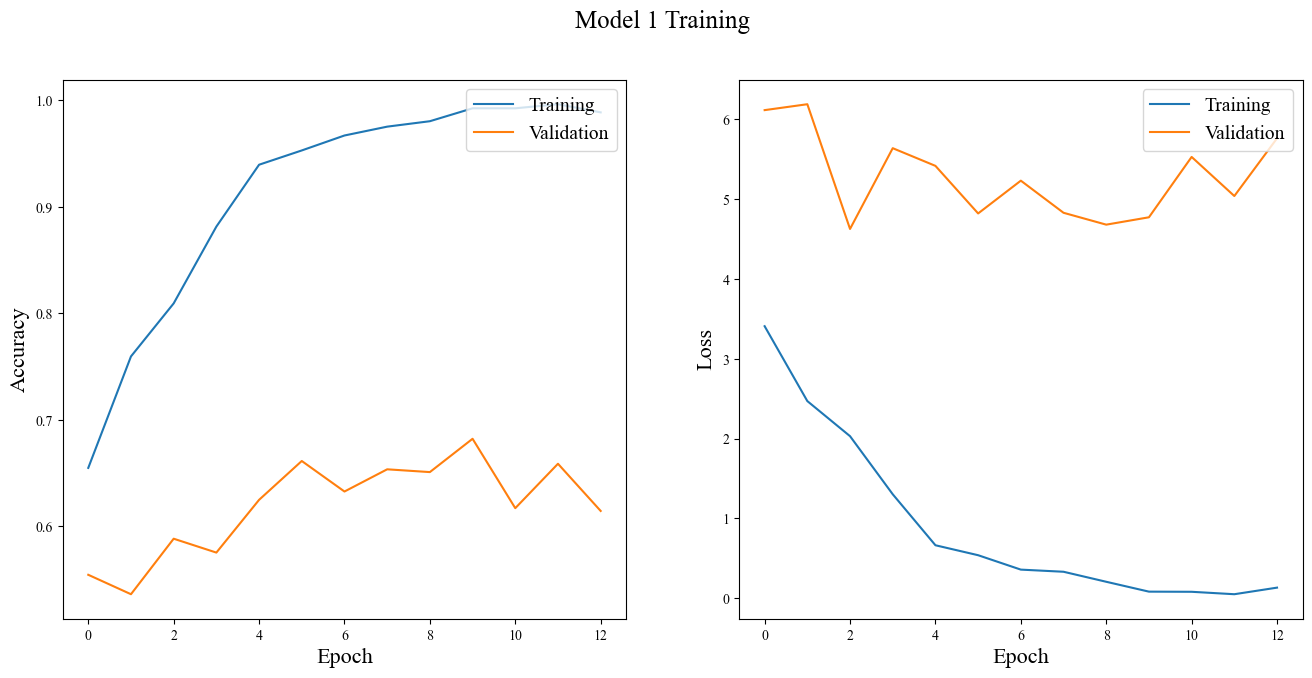

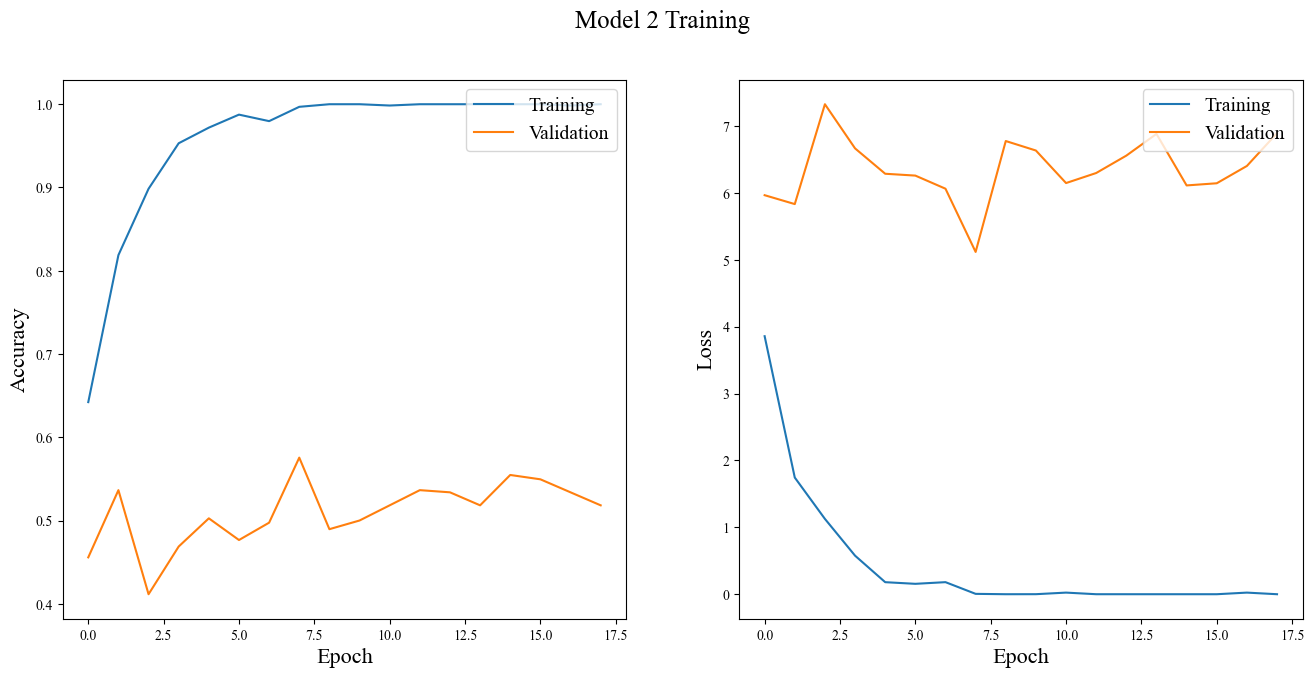

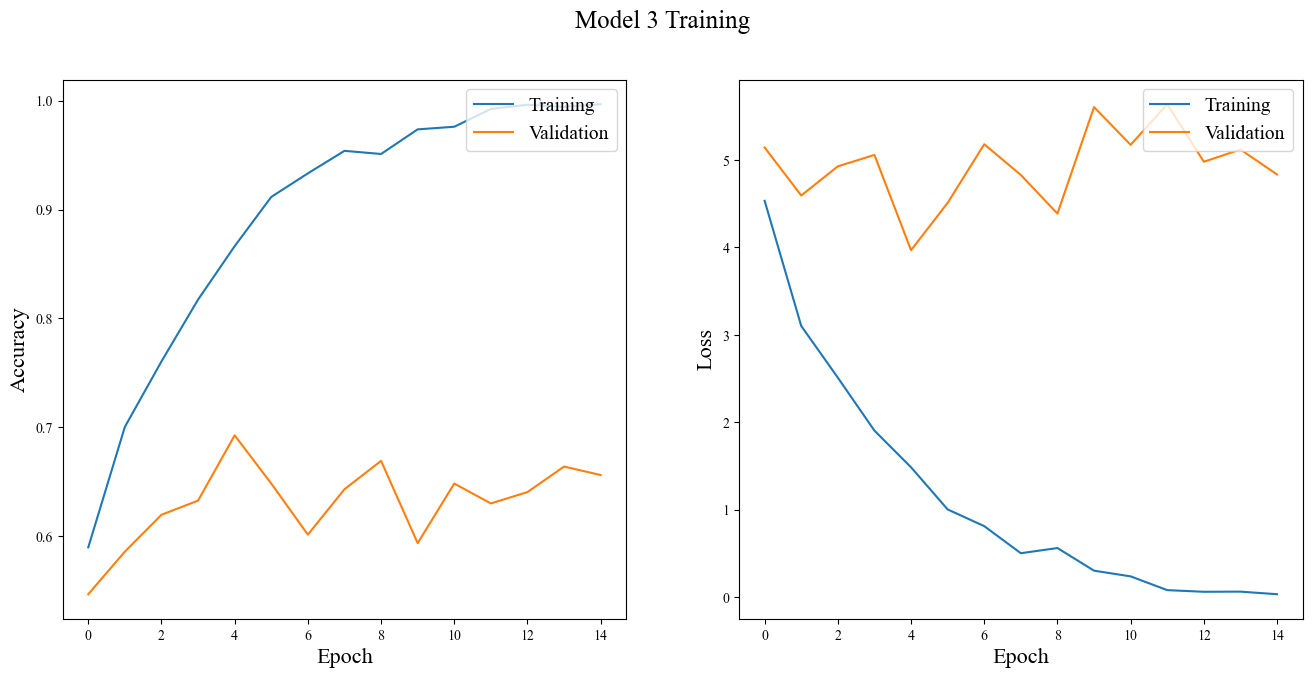

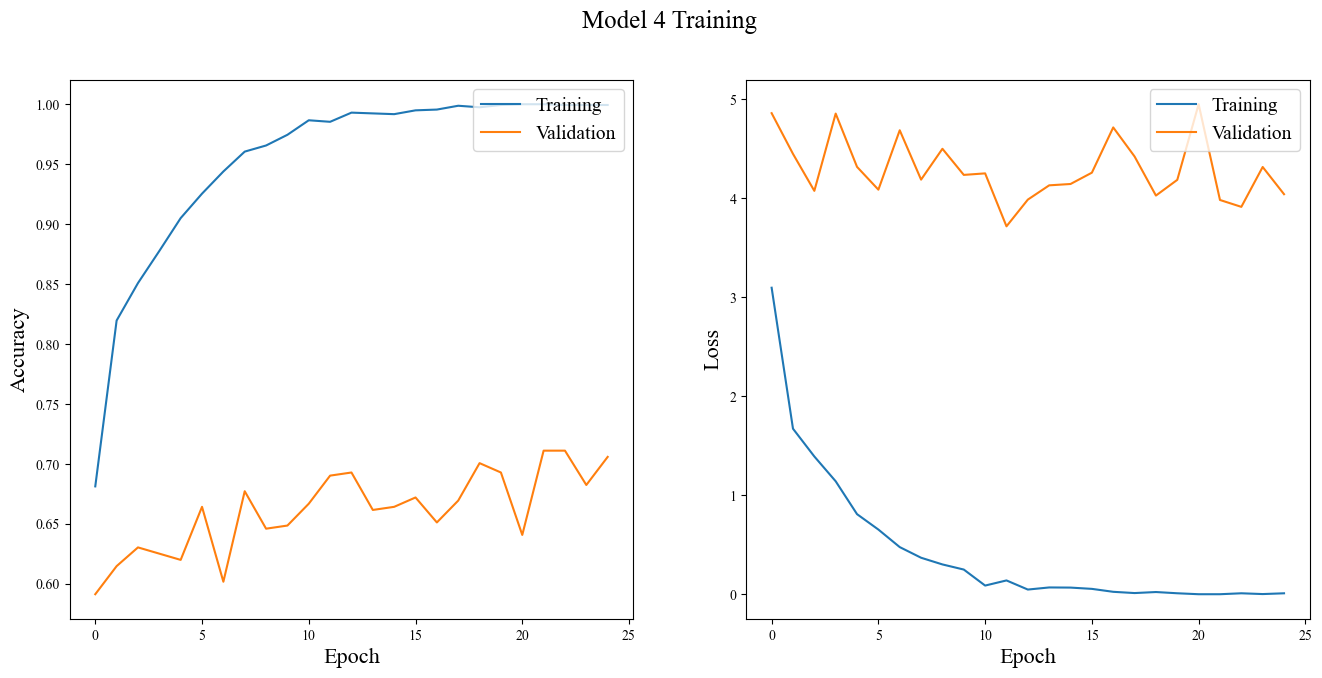

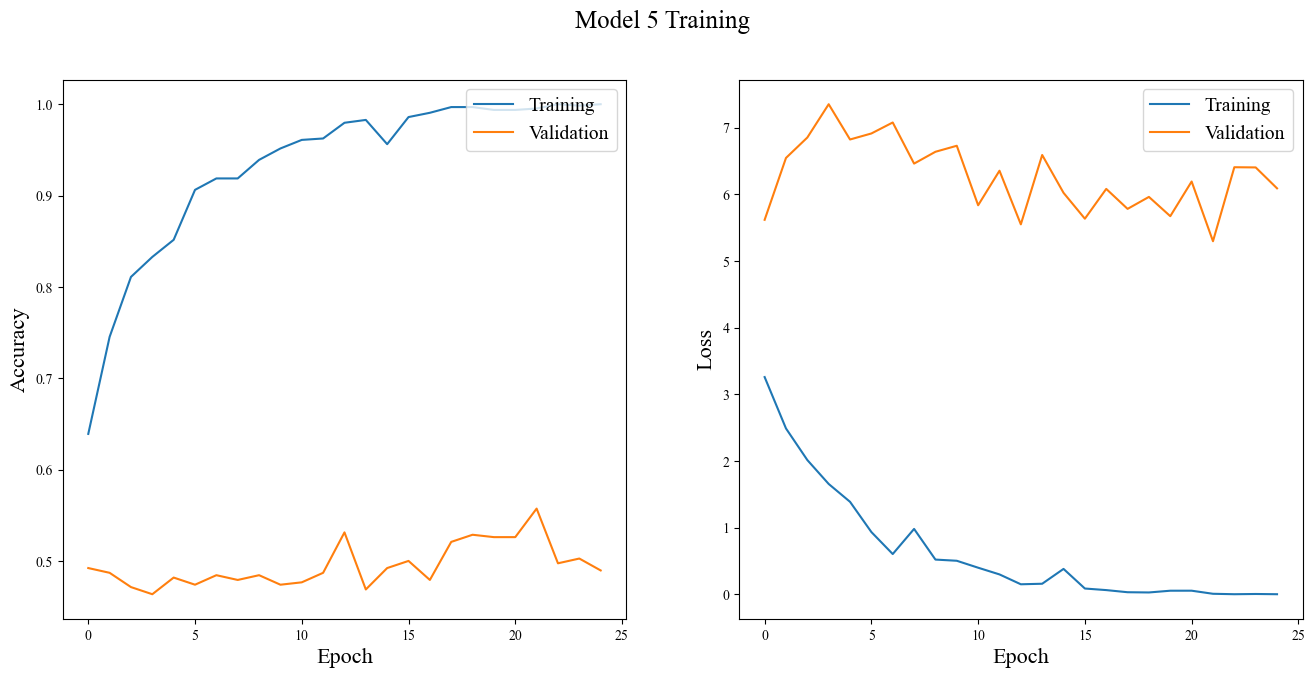

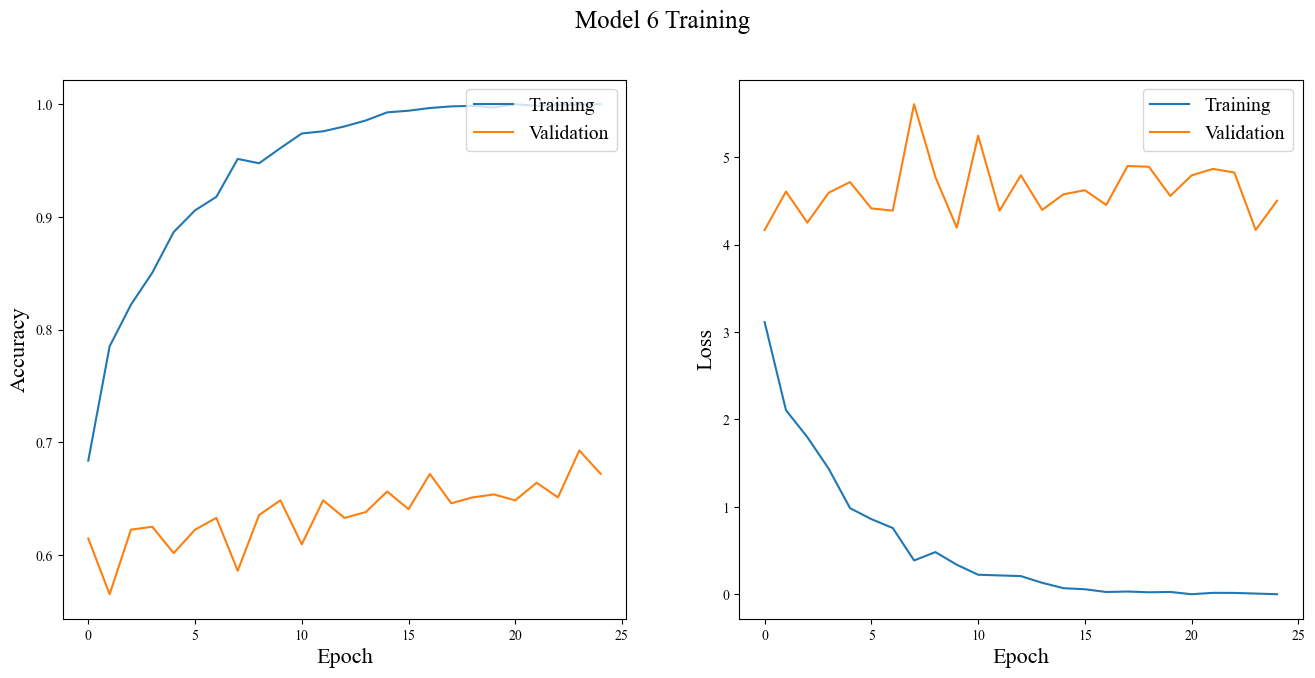

In [13]:
## Automated Training ###
if ('models' not in os.listdir(CWD)):
    os.mkdir(f'{CWD}/models/')
for i in range(1,7):
    validation_loader = loader_val
    if (i % 3 == 1):
        loader = loader_dataset1
    elif (i % 3 == 2):
        loader = loader_dataset2
    elif (i % 3 == 0):
        loader = loader_dataset3
    
    if (i <= 3):
        completed_epochs, metrics = train_base_CNN(i, loader, params_CNN, validation_loader)
    elif (i <= 6):
        completed_epochs, metrics = train_DB_VAE(i, loader, params_DB_VAE, validation_loader)

    completed.append(completed_epochs)
    training_metrics.append(metrics)

    tf.keras.backend.clear_session()

## Research Ethics
This code makes use of the mitdeeplearning package (Amini, 2024) for the data loading function. 
The DB-VAE for Models 4-6 is inspired by the Debiasing Computer Vision Lab notebook from 6.S191.

### Copyright 2024 MIT 6.S191 Introduction to Deep Learning. All Rights Reserved. 
 
Licensed under the MIT License. You may not use this file except in compliance 
with the License. Use and/or modification of this code outside of 6.S191 must 
reference: 

© MIT 6.S191: Introduction to Deep Learning 
http://introtodeeplearning.com 

In [14]:
### Model Training Metadata ###

end_time = time.localtime(time.time())

f = open(f"{CWD}/models/MODEL_INFO.txt", "a")
f.write(f"Start Time: {start_time.tm_year}/{start_time.tm_mon}/{start_time.tm_mday}, {start_time.tm_hour}:{start_time.tm_min}:{start_time.tm_sec}\n")
f.write(f"End Time: {end_time.tm_year}/{end_time.tm_mon}/{end_time.tm_mday}, {end_time.tm_hour}:{end_time.tm_min}:{end_time.tm_sec}")
f.write('\n')
f.write("params_CNN = {\n")
f.write(f'    optimizer = {params_CNN["optimizer"]}\n')
f.write(f'    batch_size = {params_CNN["batch_size"]}\n')
f.write(f'    num_epochs = {params_CNN["num_epochs"]}\n')
f.write(f'    learning_rate = {params_CNN["learning_rate"]}\n')
f.write(f'    min_lr = {params_CNN["min_lr"]}\n')
f.write(f'    factor = {params_CNN["factor"]}\n')
f.write(f'    patience_lr = {params_CNN["patience_lr"]}\n')
f.write(f'    patience_stop = {params_CNN["patience_stop"]}\n')
f.write('}\n')
f.write('\n')
f.write("params_DB_VAE = {\n")
f.write(f'    optimizer = {params_DB_VAE["optimizer"]}\n')
f.write(f'    batch_size = {params_DB_VAE["batch_size"]}\n')
f.write(f'    num_epochs = {params_DB_VAE["num_epochs"]}\n')
f.write(f'    learning_rate = {params_DB_VAE["learning_rate"]}\n')
f.write(f'    latent_dim = {params_DB_VAE["latent_dim"]}\n')
f.write('}\n')
f.write('\n')
for i in range(6):
    f.write(f'Model {i+1} completed {completed[i]} training epochs.\n')
    training_metrics[i].to_excel(f'{CWD}/models/Model_{i+1}_training_metadata.xlsx')
f.close()